In [1]:
import asyncio
import io
import glob
import os
import sys
import time
import uuid
import requests
from urllib.parse import urlparse
from io import BytesIO
from PIL import Image, ImageDraw
from azure.cognitiveservices.vision.face import FaceClient
from msrest.authentication import CognitiveServicesCredentials
from azure.cognitiveservices.vision.face.models import APIErrorException

from azure.cognitiveservices.vision.face.models import TrainingStatusType, Person
from tqdm import tqdm
import json
import tensorflow as tf
import numpy as np
sys.path.append("../")
from utils import prewhiten, l2_normalize
from attacks.attack import Attacker
from sklearn.metrics import pairwise_distances, roc_auc_score
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn
seaborn.set()

## Set Up, Load Model, and Images

In [2]:
model_path = '/home/ivan/pascal_adversarial_faces/keras-facenet/model/facenet_keras.h5'

In [3]:
auth_file = "/home/ivan/azure_auth.json"
with open(auth_file, "r") as f:
    auth_data = json.loads(f.read())
face_client = FaceClient(
    auth_data["endpoint"], 
    CognitiveServicesCredentials(auth_data["key"])
)

In [4]:
model = tf.keras.models.load_model(model_path)

In [5]:
class PersonImages:
    def __init__(self, person_name):
        self.clean_folder = ""
        self.clean_images = []
        self.adversarial_images = []
        self.reloaded_adversarial_images = []
        self.orig_mean = None
        self.orig_std = None
        self.person_name = person_name
        self.adversarial_save_folder = None
    
    def _load_one_facenet(self, path, crop_box=None, resize_size=None, prewhiten=True):
        img = Image.open(path).convert("RGB")
        
        if crop_box:
            img = img.crop(crop_box)
            
        if resize_size:
            img = img.resize((resize_size, resize_size))
            
        img = (np.array(img)).astype(np.float32)
        
        if prewhiten:
            img = prewhiten(img)
            
        return img
        
        
    def _load_folder_for_facenet(self, folder, crop=False, resize_size=None):
        paths_list = glob.glob(os.path.join(folder, self.person_name + "*"))
        
        final_imgs = []
        for img_path in paths_list:
            
            if crop:
                results = face_client.face.detect_with_stream(
                    open(img_path, "r+b"), 
                    detectionModel='detection_02'
                )
                crop_box = (
                    results[0].face_rectangle.left,
                    results[0].face_rectangle.top,
                    results[0].face_rectangle.left + results[0].face_rectangle.width,
                    results[0].face_rectangle.top + results[0].face_rectangle.height
                )
            else:
                crop_box = None
                
            final_imgs.append(
                self._load_one_facenet(
                    img_path, crop_box=crop_box, prewhiten=False, resize_size=resize_size))
        
        final_imgs = np.array(final_imgs)
        mean, std = np.mean(final_imgs), np.std(final_imgs)
        final_imgs = prewhiten(np.array(final_imgs))
        return final_imgs, mean, std
        
        
    def load_clean_from_folder(self, clean_folder, resize_size=160, crop=True):
        self.clean_folder = clean_folder
        self.clean_images, self.orig_mean, self.orig_std = self._load_folder_for_facenet(
            clean_folder, crop=crop, resize_size=resize_size)
    
    def _load_plain(self, folder):
        imgs, mean, std = self._load_folder_for_facenet(folder, crop=False, resize_size=None)
        return imgs
        
    def reload_adversarial(self):
        self.reloaded_adversarial_images = self._load_plain(self.adversarial_save_folder)
        
    def _undo_preprocess(self, images):
        restored_images = images.copy()
        restored_images  *= self.orig_std
        restored_images += self.orig_mean
        restored_images = np.clip(restored_images, 0.0, 255.0)
        return np.uint8(restored_images)
    
    def get_clean_for_display(self):
        return self._undo_preprocess(self.clean_images)
    
    def get_adversarial_for_display(self):
        return self._undo_preprocess(self.adversarial_images)
    
    def save_adversarial(self, save_path, save_format):
        self.adversarial_save_folder = save_path
        self.adversarial_save_format = save_format
        adversarial_for_save = self.get_adversarial_for_display()
        
        for indx, img in enumerate(adversarial_for_save):
            Image.fromarray(img).save(
                os.path.join(save_path, f"{self.person_name}_{indx:02d}.{self.adversarial_save_format}")
            )
            
    def _compute_embeddings(self, model, images):
        return model.predict(np.array(images), batch_size=len(images))
    
    def compute_clean_embeddings_with_model(self, model):
        self.clean_embeddings = self._compute_embeddings(model, self.clean_images)
        
    def compute_adversarial_embeddings_with_model(self, model):
        self.adversarial_embeddings = self._compute_embeddings(model, self.adversarial_images)
        
    def compute_reloaded_adversarial_embeddings_with_model(self, model):
        self.reloaded_adversarial_embeddings = self._compute_embeddings(model, self.reloaded_adversarial_images)
    

In [6]:
yoshi = PersonImages("yoshi")
yoshi.load_clean_from_folder("/data/ivan_yoshi_pascal")
yoshi.compute_clean_embeddings_with_model(model)

In [7]:
ivan = PersonImages("ivan")
ivan.load_clean_from_folder("/data/ivan_yoshi_pascal")
ivan.compute_clean_embeddings_with_model(model)

## Sanity Checks

In [8]:
def roc_curve(positive, negative):
    ground_truth = [0 for x in positive] + [5 for x in negative]
    scores = np.concatenate((positive, negative), axis=0)
    print(ground_truth)
    print(scores)

    roc_auc = roc_auc_score(
        y_true=ground_truth,
        y_score=scores, 
    )
    print(f"Computed ROC AUC: {roc_auc:.3f}")
    
    thresholds = np.arange(1e-6, 2.0, 0.1)
    tprs = []
    fprs = []
    n_pos = float(len(positive))
    n_neg = float(len(negative))

    print("**** Computing ROC curve *****")
    for t in thresholds:
        tp = np.sum(positive < t)
        fp = np.sum(negative < t)
        tprs.append(tp / n_pos)
        fprs.append(fp / n_neg)

    plt.plot(np.arange(0.0, 1.1, 0.1), np.arange(0.0, 1.1, 0.1), label="y=x")
    plt.plot(fprs, tprs, label="ResNet50 VGGFace2")
    plt.legend()
    plt.ylabel("True Positive Rate")
    plt.xlabel("False Positive Rate")
    plt.title("ROC Curve for model")

In [9]:
def sanity_check(model, person_a, person_b):    
    self_distances = pairwise_distances(
         l2_normalize(person_a.clean_embeddings),
         l2_normalize(person_a.clean_embeddings),
         metric='euclidean',
         n_jobs=4
    )
    # all distances below the diagonal compare every pair and exclude 0's to self
    self_dist_indices = np.tril_indices(n=len(person_a.clean_embeddings), k=-1)
    
    # this selection returns a flattened array of distances that are ground truth True
    self_distances = self_distances[self_dist_indices]

    negative_distances = pairwise_distances(
        l2_normalize(person_a.clean_embeddings),
        l2_normalize(person_b.clean_embeddings),
        metric='euclidean',
        n_jobs=4
    ).flatten()

    roc_curve(self_distances, negative_distances)
    
    fig1, ax1 = plt.subplots()
    ax1.boxplot([self_distances, negative_distances])

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]
[0.62813276 0.57702243 0.64942336 0.6579497  0.49939787 0.49929366
 1.0669593  1.048372   1.0416833  0.9939346  0.9132615  0.9664309
 0.8402168  0.84151614 1.0872209  1.1389593  1.2582744  1.1849751
 1.3526182  1.3678867  1.2516896  1.113844   1.2425411  1.1046846
 1.3267984  1.3344697  1.2549847  1.0505704  1.1730539  1.0919322
 1.3375556  1.3071434  1.1375008  1.0900446  1.221624   1.0688397
 1.341228   1.2713959  1.2067956  1.2133383  1.2506438  1.1444983
 1.3773073  1.2554816  1.246726   1.1911813  1.1505864  1.0269709
 1.3506796  1.2565763  1.1842588 ]
Computed ROC AUC: 0.987
**** Computing ROC curve *****


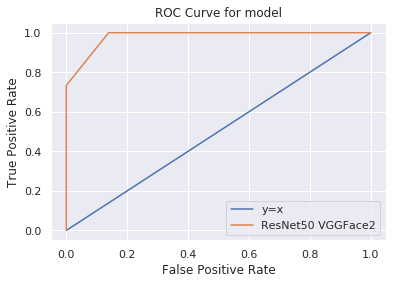

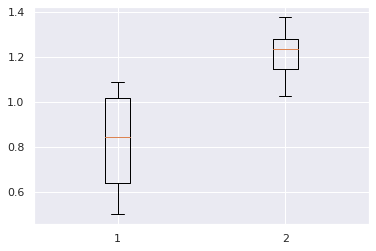

In [10]:
sanity_check(model, ivan, yoshi)

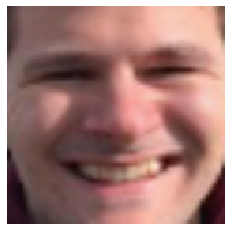

In [11]:
plt.axis('off')
plt.imshow(ivan.get_clean_for_display()[0])

## Attack Experiments

In [12]:
class PlainAttacker(Attacker):
    def _get_default_kwargs(self, kwargs, image_batch):
        """
        Gets some default values for existing hyper-parameters.
        """
        if 'bounds' not in kwargs:
            kwargs['bounds'] = [tf.reduce_min(image_batch), tf.reduce_max(image_batch)]
        if 'num_iters' not in kwargs:
            kwargs['num_iters'] = 400
        if 'patience' not in kwargs:
            kwargs['patience'] = 5
        if 'alpha' not in kwargs:
            kwargs['alpha'] = 0.001
        if 'verbose' not in kwargs:
            kwargs['verbose'] = False
        return kwargs


    def target_vector_attack(
        self, 
        image_batch, 
        target_embedding, 
        normalize_target_embedding=True, 
        epsilon=0.1, 
        **kwargs
    ):
        """
        Attacks a batch of images using PGD using the
        target-image strategy.
        Args:
            image_batch: A batch of images. The images to perturb.
            target_embedding: the target embeddings to send adversarial images to
            normalize_target_embedding: if True, l2 normalizes the target_embedding
            epsilon: Maximum perturbation amount
            kwargs: Varies depending on attack.
        """
        kwargs = self._get_default_kwargs(kwargs, image_batch)
        image_batch  = tf.convert_to_tensor(image_batch.copy())
        target_embedding = tf.convert_to_tensor(target_embedding, dtype=tf.float32)
        
        if normalize_target_embedding:
            target_embedding = self._l2_normalize(target_embedding)
        
        perturbed_image_batch = image_batch

        previous_difference = np.inf
        best_perturbation = perturbed_image_batch
        patience_count = 0

        iterable = range(kwargs['num_iters'])
        if kwargs['verbose']:
            iterable = tqdm(iterable)
        
        self.losses = []
        for i in iterable:
            with tf.GradientTape() as tape:
                tape.watch(perturbed_image_batch)
                
                batch_embedding = self.model(perturbed_image_batch)
        
                batch_embedding = self._l2_normalize(batch_embedding)
            
                difference = self._l2_distance(target_embedding, batch_embedding)
                mean_difference = tf.reduce_mean(difference)
                
                self.losses.append(mean_difference)
                
            if mean_difference < previous_difference:
                previous_difference = mean_difference
                best_perturbation = perturbed_image_batch
                patience_counnt = 0
            elif patience_count >= kwargs['patience']:
                break
            else:
                patience_count += 1

            gradient = tape.gradient(difference, perturbed_image_batch)
            sign_of_gradient = tf.cast(tf.sign(gradient), perturbed_image_batch.dtype)

            # Subtract the gradient because we want to minimize the distance
            perturbed_image_batch = perturbed_image_batch - sign_of_gradient * kwargs['alpha']
            perturbed_image_batch = tf.clip_by_value(perturbed_image_batch, image_batch - epsilon, image_batch + epsilon)
            perturbed_image_batch = tf.clip_by_value(perturbed_image_batch, kwargs['bounds'][0], kwargs['bounds'][1])

        return best_perturbation

In [13]:
class ExperimentalAttacker(Attacker):
    def _get_default_kwargs(self, kwargs, image_batch):
        """
        Gets some default values for existing hyper-parameters.
        """
        if 'bounds' not in kwargs:
            kwargs['bounds'] = [tf.reduce_min(image_batch), tf.reduce_max(image_batch)]
        if 'num_iters' not in kwargs:
            kwargs['num_iters'] = 400
        if 'patience' not in kwargs:
            kwargs['patience'] = 5
        if 'alpha' not in kwargs:
            kwargs['alpha'] = 0.001
        if 'verbose' not in kwargs:
            kwargs['verbose'] = False
        return kwargs


    def target_vector_attack(
        self, 
        image_batch, 
        target_embedding, 
        normalize_target_embedding=True, 
        epsilon=0.1, 
        **kwargs
    ):
        """
        Attacks a batch of images using PGD using the
        target-image strategy.
        Args:
            image_batch: A batch of images. The images to perturb.
            target_embedding: the target embeddings to send adversarial images to
            normalize_target_embedding: if True, l2 normalizes the target_embedding
            epsilon: Maximum perturbation amount
            kwargs: Varies depending on attack.
        """
        kwargs = self._get_default_kwargs(kwargs, image_batch)
        image_batch  = tf.convert_to_tensor(image_batch.copy())
        target_embedding = tf.convert_to_tensor(target_embedding, dtype=tf.float32)
        
        if normalize_target_embedding:
            target_embedding = self._l2_normalize(target_embedding)
        
        perturbed_image_batch = image_batch

        previous_difference = np.inf
        best_perturbation = perturbed_image_batch
        patience_count = 0

        iterable = range(kwargs['num_iters'])
        if kwargs['verbose']:
            iterable = tqdm(iterable)
        
        self.losses = []
        for i in iterable:
            with tf.GradientTape() as tape:
                tape.watch(perturbed_image_batch)
                
                if i < kwargs['iters_no_rand']:
                    batch_input_to_model = perturbed_image_batch
                else:
                    batch_input_to_model = tf.image.random_flip_left_right(perturbed_image_batch)
                    batch_input_to_model = tf.image.random_brightness(batch_input_to_model, max_delta=0.25)
    #                 batch_input_to_model = tf.image.random_jpeg_quality(batch_input_to_model, 5, 90)

                    batch_input_to_model += tf.random.normal(batch_input_to_model.shape, 0.0, 0.5)
    
                batch_embedding = self.model(batch_input_to_model)
        
                batch_embedding = self._l2_normalize(batch_embedding)
            
                difference = self._l2_distance(target_embedding, batch_embedding)
                mean_difference = tf.reduce_mean(difference)
                
                self.losses.append(mean_difference)
                
            if mean_difference < previous_difference:
                previous_difference = mean_difference
                best_perturbation = perturbed_image_batch

            gradient = tape.gradient(difference, perturbed_image_batch)
            sign_of_gradient = tf.cast(tf.sign(gradient), perturbed_image_batch.dtype)

            # Subtract the gradient because we want to minimize the distance
            perturbed_image_batch = perturbed_image_batch - sign_of_gradient * kwargs['alpha']
            perturbed_image_batch = tf.clip_by_value(perturbed_image_batch, image_batch - epsilon, image_batch + epsilon)
            perturbed_image_batch = tf.clip_by_value(perturbed_image_batch, kwargs['bounds'][0], kwargs['bounds'][1])

        return best_perturbation

In [19]:
def run_attack(
    attacker, 
    person_to_modify,
    person_to_target,
    num_iters=600,
    epsilon=0.25,
    iters_no_rand=10,
    alpha=0.01,
):
    target_embeddings = np.expand_dims(np.mean(person_to_target.clean_embeddings, axis=0), 0)
    person_to_modify.adversarial_images = np.array(attacker.target_vector_attack(
        person_to_modify.clean_images, 
        target_embeddings,
        normalize_target_embedding=False, 
        num_iters=num_iters,
        epsilon=epsilon,
        iters_no_rand=iters_no_rand,
        alpha=alpha
    ))
    person_to_modify.compute_adversarial_embeddings_with_model(attacker.model)

    scratch_folder = "/home/ivan/ivan_yoshi_adversarial_faces"
    for f in os.listdir(scratch_folder):
        os.remove(os.path.join(scratch_folder, f))
    
    person_to_modify.save_adversarial(scratch_folder, "jpeg")
    person_to_modify.reload_adversarial()
    person_to_modify.compute_reloaded_adversarial_embeddings_with_model(model)
    
    
def clean_to_adv_for_person(person):
    return pairwise_distances(
         person.clean_embeddings,
         person.adversarial_embeddings,
         metric='euclidean',
    ).flatten()


def clean_to_adv_reloaded_for_person(person):
    return pairwise_distances(
         person.clean_embeddings,
         person.reloaded_adversarial_embeddings,
         metric='euclidean',
    ).flatten()


def person_self(person):
    return pairwise_distances(
         person.clean_embeddings,
         person.clean_embeddings,
         metric='euclidean',
    )[np.tril_indices(len(person.clean_embeddings), k=-1)]
    
    
def visualize_attack(attacker, person_a, person_b):
    ax1 = plt.subplot(1, 1, 1)
    ax1.axis("off")
    ax1.imshow(person_a.get_adversarial_for_display()[0])
    plt.show()
    
    ax2 = plt.subplot(1, 1, 1)
    ax2.plot(range(len(attacker.losses)), attacker.losses)
    plt.show()
    
    diff = person_a._undo_preprocess(
        np.abs(person_a.clean_images[0]) - np.array(person_a.adversarial_images[0])
    )
    ax3 = plt.subplot(1, 1, 1)
    ax3.axis("off")
    ax3.imshow(diff)
    plt.show()
    
    a_clean_adv = clean_to_adv_for_person(person_a)
    b_clean_adv = clean_to_adv_for_person(person_b)
    
    a_b_clean = pairwise_distances(
         person_a.clean_embeddings,
         person_b.clean_embeddings,
         metric='euclidean',
    ).flatten()
    
    a_b_adversarial = pairwise_distances(
         person_a.adversarial_embeddings,
         person_b.adversarial_embeddings,
         metric='euclidean',
    ).flatten()
    
    a_clean_clean = person_self(person_a)
    b_clean_clean = person_self(person_b)

    a_adv_b_clean = pairwise_distances(
         person_a.adversarial_embeddings,
         person_b.clean_embeddings,
         metric='euclidean',
    ).flatten()
    
    a_clean_b_adv = pairwise_distances(
         person_a.clean_embeddings,
         person_b.adversarial_embeddings,
         metric='euclidean',
    ).flatten()
    
    
    reloaded_a_clean_adv = clean_to_adv_reloaded_for_person(person_a)
    reloaded_b_clean_adv = clean_to_adv_reloaded_for_person(person_b)
    reloaded_a_b_adversarial = pairwise_distances(
         person_a.reloaded_adversarial_embeddings,
         person_b.reloaded_adversarial_embeddings,
         metric='euclidean',
    ).flatten()
    reloaded_a_adv_b_clean = pairwise_distances(
         person_a.reloaded_adversarial_embeddings,
         person_b.clean_embeddings,
         metric='euclidean',
    ).flatten()
    reloaded_a_clean_b_adv = pairwise_distances(
         person_a.clean_embeddings,
         person_b.reloaded_adversarial_embeddings,
         metric='euclidean',
    ).flatten()

    fig1, ax1 = plt.subplots(figsize=(10, 10))
    ax1.boxplot([
        a_clean_adv, 
        b_clean_adv, 
        a_b_clean, 
        a_b_adversarial, 
        a_clean_clean, 
        b_clean_clean,
        a_adv_b_clean, 
        a_clean_b_adv,
        reloaded_a_clean_adv,
        reloaded_b_clean_adv,
        reloaded_a_b_adversarial,
        reloaded_a_adv_b_clean,
        reloaded_a_clean_b_adv
    ])
    ax1.set_xticklabels([
            f"{person_a.person_name} clean <-> {person_a.person_name} adversarial", 
            f"{person_b.person_name} clean <-> {person_b.person_name} adversarial",
            f"{person_a.person_name} clean <-> {person_b.person_name}  clean", 
            f"{person_a.person_name} adversarial <-> {person_b.person_name}  adversarial", 
            f"{person_a.person_name} clean <-> {person_a.person_name}  clean", 
            f"{person_b.person_name} clean <-> {person_b.person_name}  clean", 
            f"{person_a.person_name} adversarial <-> {person_b.person_name} clean", 
            f"{person_b.person_name} adversarial <-> {person_a.person_name} clean",
            f"RELOADED {person_a.person_name} clean <-> {person_a.person_name} adversarial", 
            f"RELOADED {person_b.person_name} clean <-> {person_b.person_name} adversarial",
            f"RELOADED {person_a.person_name} adversarial <-> {person_b.person_name}  adversarial", 
            f"RELOADED {person_a.person_name} adversarial <-> {person_b.person_name} clean", 
            f"RELOADED {person_b.person_name} adversarial <-> {person_a.person_name} clean",
        ], 
        rotation=90, fontsize=12
    )
    

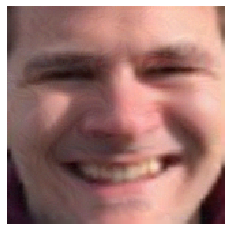

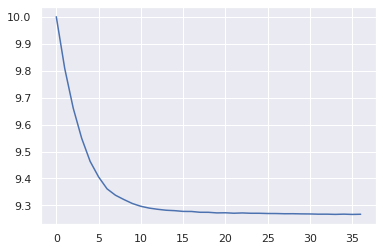

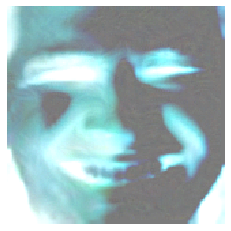

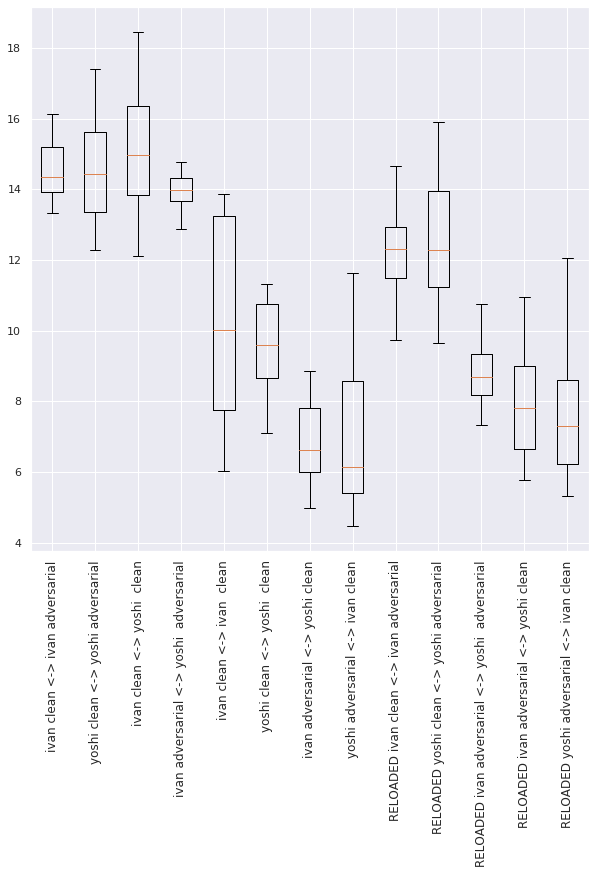

In [20]:
plain_attacker = PlainAttacker(model)
run_attack(plain_attacker, ivan, yoshi)
run_attack(plain_attacker, yoshi, ivan)
visualize_attack(plain_attacker, ivan, yoshi)

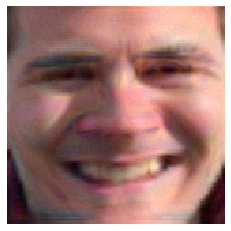

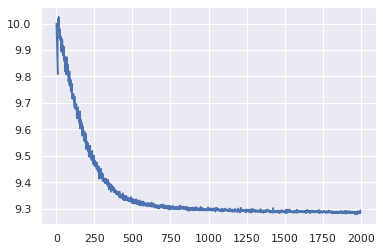

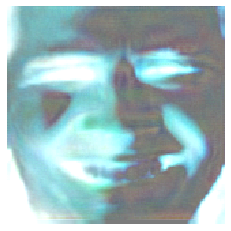

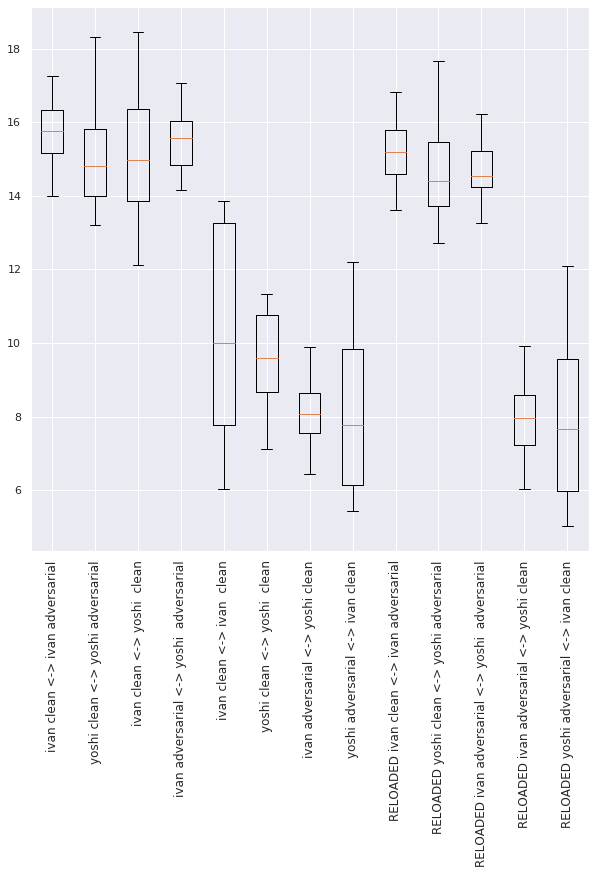

In [21]:
exp_attacker = ExperimentalAttacker(model)
run_attack(
    exp_attacker, 
    ivan,
    yoshi, 
    num_iters=2000,
    epsilon=0.5,
    iters_no_rand=10,
    alpha=0.001
)
run_attack(
    exp_attacker, 
    yoshi,
    ivan, 
    num_iters=2000,
    epsilon=0.5,
    iters_no_rand=10,
    alpha=0.001
)
visualize_attack(exp_attacker, ivan, yoshi)

## Test on Azure

In [22]:
PERSON_GROUP_NAME = "ivan_yoshi_strong_attack"
if PERSONG_GROUP_NAME in [x.id for face_client.person_group.list()]:
    face_client.person_group.delete(person_group_id=PERSON_GROUP_NAME)

SyntaxError: invalid syntax (<ipython-input-22-aac42928e137>, line 2)

In [ ]:
class PersonGroupExistsError(ValueError):
    pass


class PersonGroupInterface:
    def __init__(self, person_group_name, endpoint, key):
        self.face_client = FaceClient(
            endpoint, CognitiveServicesCredentials(key))
        self.person_group_name = person_group_name
        self._verify_person_group_does_not_exist(person_group_name)
        self.name_to_person_obj = {}
        self.face_client.person_group.create(
            person_group_id=self.person_group_name,
            name=self.person_group_name
        )

    def _verify_person_group_does_not_exist(self, person_group_name):
        # Check if person group exists on Azure instance
        existing_pg = self.face_client.person_group.list()
        for gr in existing_pg:
            if gr.name == person_group_name or gr.person_group_id == person_group_name:
                raise PersonGroupExistsError(
                    f"Group {person_group_name} already exists; please delete or fix accordingly"
                )

    def create_person_for_each_identity(self, identities):
        for person_name in identities:
            self.name_to_person_obj[person_name] = self.face_client.person_group_person.create(
                self.person_group_name, person_name
            )

    def _add_folder(self, folder_path, person_name):
        # List all jpeg, jpg and png images
        # glob returns full paths
        file_paths = [fn for fn in glob.glob(
            os.path.join(folder_path, person_name + '*')
        ) if fn.endswith("png") or fn.endswith("jpg") or fn.endswith("jpeg")]

        print(f"Adding folder {folder_path}")
        # Add to Azure instance
        for img_path in tqdm(file_paths):
            try:
                self.face_client.person_group_person.add_face_from_stream(
                    self.person_group_name,
                    self.name_to_person_obj[person_name].person_id,
                    open(img_path, "r+b")
                )
            except APIErrorException as e:
                print(f"Exception {e} for image {img_path}")
            # Sleep to avoid triggering rate limiters
            time.sleep(10)

    def add_images(
            self, image_directory, people_names):
       
        for person in people_names:
            self._add_folder(image_directory, person)


    def train(self):
        print()
        print('Training the person group...')
        # Train the person group
        self.face_client.person_group.train(self.person_group_name)

        while (True):
            training_status = self.face_client.person_group.get_training_status(self.person_group_name)
            print("Training status: {}.".format(training_status.status))
            print()
            if (training_status.status is TrainingStatusType.succeeded):
                break
            elif (training_status.status is TrainingStatusType.failed):
                sys.exit('Training the person group has failed.')
            time.sleep(5)

In [ ]:
pgi = PersonGroupInterface("ivan_yoshi_strong_attack", endpoint=auth_data["endpoint"], key=auth_data["key"])
pgi.create_person_for_each_identity(["yoshi", "ivan"])
pgi.add_images("/home/ivan/ivan_yoshi_adversarial_faces", ["yoshi", "ivan"])

In [ ]:
pgi.train()

In [ ]:
def get_discovery_for_identities(person_id_to_name, folder_path, person_group_name):
    discovery = []
    identities = person_id_to_name.values()
    
    for identity in tqdm(identities):  
        query_photos_paths = glob.glob(os.path.join(folder_path, identity + "*"))
        
        for path in query_photos_paths:
            faces_in_query_photos = face_client.face.detect_with_stream(
                open(path, "r+b"), 
                detectionModel='detection_02'
            )
            if len(faces_in_query_photos) > 1:
                print(f"Found more than one faces {len(faces_in_query_photos)}")
                break


            # There should only be one face, so we use that as the query face.
            results = face_client.face.identify(
                [faces_in_query_photos[0].face_id],
                person_group_name
            )

            if len(results) < 1 or len(results[0].candidates) < 1:
                discovery.append(1.0)

            else: 
                top_identity = person_id_to_name[results[0].candidates[0].person_id]
                confidence = results[0].candidates[0].confidence
                print(f"Top identity for image {path} is {top_identity} with confidence {confidence:.3f}")
                # Note the switch of the term protector here:
                # protectors are also protected but we call them protectors because of the folder structure
                # In this case, the query photo belongs to the protector -- who is also protected by decoys 
                # of *other* protectors. Therefore, if the identity returned is that of the "protector,"
                # this is a failure in the defense.
                if top_identity == identity:
                    discovery.append(1.0)
                else:
                    discovery.append(0.0)

            time.sleep(10)
        
    return sum(discovery)/len(discovery)

In [ ]:
reverse_person_id_to_name = {pgi.name_to_person_obj[p].person_id: p for p in pgi.name_to_person_obj.keys()}
print(reverse_person_id_to_name)

In [ ]:
print(get_discovery_for_identities(
    reverse_person_id_to_name,
    "/data/ivan_yoshi_pascal",
    "ivan_yoshi_strong_attack"
))